In [1]:
import numpy as np
import pandas as pd
import zipfile
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import mixed_precision
import gc
import os
from monitor import ResourceMonitor

# Bật mixed precision
mixed_precision.set_global_policy('mixed_float16')
tf.get_logger().setLevel('ERROR')
tf.config.optimizer.set_jit(True)  # Bật XLA để tối ưu hóa
dask.config.set({"distributed.diagnostics.nvml": False})
# Cấu hình Dask Client với giới hạn tài nguyên (12GB RAM)
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=2, memory_limit='4GB')
print(client)

input_files = [f"file{i+1}" for i in range(3)]
temp_dir = "FL_Data/"
input_files = [temp_dir + output_file for output_file in input_files]
print(input_files)

# Đọc dữ liệu Parquet với Dask, chỉ lấy metadata để giảm tải
df = [dk.read_parquet(file, columns=None) for file in input_files]  # Chỉ đọc metadata
print(df[1].dtypes)

batch_size = 512  # Tăng batch_size để giảm số bước
ratio_test_all = 0.2
features_len = len(df[0].columns) - 1  # Giả định tất cả file có cùng cấu trúc
print("Feature Len:", features_len)

# Ước lượng số lượng mẫu từ metadata thay vì tính chính xác
train_sizes = [df_i.shape[0].compute() * (1 - ratio_test_all) for df_i in df]
val_sizes = [df_i.shape[0].compute() * ratio_test_all * 0.25 for df_i in df]
test_sizes = [df_i.shape[0].compute() * ratio_test_all * 0.75 for df_i in df]

train_dfs = []
val_dfs = []
test_dfs = []
for dff in df:
    train_df, val_test_df = dff.random_split([1 - ratio_test_all, ratio_test_all], shuffle=True)
    test_df, val_df = val_test_df.random_split([0.75, 0.25], shuffle=True)
    train_dfs.append(train_df)
    val_dfs.append(val_df)
    test_dfs.append(test_df)

def dask_to_tf_dataset(dask_df, batch_size, features_len):
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()
            if batch.empty:
                continue
            X = batch.drop(columns=['label']).values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)
            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)
            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch
    output_signature = (
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    return dataset.cache().prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=1000)

train_gens = [dask_to_tf_dataset(train_df, batch_size, features_len).repeat() for train_df in train_dfs]
val_gens = [dask_to_tf_dataset(val_df, batch_size, features_len).repeat() for val_df in val_dfs]
test_gens = [dask_to_tf_dataset(test_df, batch_size, features_len).repeat() for test_df in test_dfs]

from server_multi_no_PP import Server
from client_multi_no_PP import Client
import datetime

num_servers = 1
num_clients = 3

# Ước lượng steps
stepsPerEpoch_Clients = [int(np.ceil(size / batch_size)) for size in train_sizes]
stepsValidate_Clients = [int(np.ceil(size / batch_size)) for size in val_sizes]
stepsTest_Clients = [int(np.ceil(size / batch_size)) for size in test_sizes]

active_servers_list = ['server_' + str(i) for i in range(num_servers)]
active_clients_list = ['client_' + str(i) for i in range(num_clients)]
print(active_servers_list)
print(active_clients_list)

agents_dict = {}
serverObjects = {server_name: Server(server_name=server_name, active_clients_list=active_clients_list)
                 for server_name in active_servers_list}

clientObjects = {client_name: Client(client_name, train_gens[clientID], val_gens[clientID], test_gens[clientID],
                                     stepsPerEpoch_Clients[clientID], stepsValidate_Clients[clientID], stepsTest_Clients[clientID],
                                     active_clients_list=active_clients_list)
                 for clientID, client_name in enumerate(active_clients_list)}

temp_dir_log = clientObjects['client_0'].get_temp_dir()
for index, client_name in enumerate(active_clients_list):
    clientObjects[client_name].get_steps_per_epoch()
    clientObjects[client_name].get_validation_steps()
    clientObjects[client_name].get_test_steps()

agents_dict['server'] = serverObjects
agents_dict['client'] = clientObjects

for agent_name, agent in serverObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)
for agent_name, agent in clientObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)

# Giải phóng tài nguyên không cần thiết
del train_dfs, val_dfs, test_dfs, df
gc.collect()

server = agents_dict['server']['server_0']
if __name__ == '__main__':
    monitor = ResourceMonitor(interval=1, gpu_id=0)
    monitor.start()
    try:
        server.InitLoop()
        server.final_statistics()
    finally:
        # 3. Dừng monitor và lưu kết quả, bất kể có lỗi hay không
        resource_df = monitor.stop()
        resource_usage = os.path.join(temp_dir_log, "resource_usage.csv")
        resource_df.to_csv(resource_usage, index=False)
        print(f"Đã lưu kết quả giám sát tài nguyên vào file: {resource_usage}")
        client.close()  # Đóng Dask Client sau khi hoàn tất

2025-06-24 15:10:07.371411: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 15:10:07.411410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750752607.441103   91803 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750752607.450657   91803 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750752607.479323   91803 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

<Client: 'tcp://127.0.0.1:46669' processes=2 threads=4, memory=7.45 GiB>
['FL_Data/file1', 'FL_Data/file2', 'FL_Data/file3']
flow_duration      float64
Header_Length      float64
Protocol Type      float64
Duration           float64
Rate               float64
Srate              float64
Drate              float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
urg_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP               float64
IPv                float64
LLC        

I0000 00:00:1750752614.150808   91803 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


['server_0']
['client_0', 'client_1', 'client_2']
Train steps: 5338
Val steps: 334
Test steps: 1001
Train steps: 3739
Val steps: 234
Test steps: 702
Train steps: 4262
Val steps: 267
Test steps: 800
====================================== Đang chạy Iteration 1 ======================================
Epoch 1/8
Epoch 1/8
Epoch 1/8


I0000 00:00:1750752617.900395   91906 service.cc:152] XLA service 0x7f2558004c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750752617.900454   91906 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
I0000 00:00:1750752617.914375   91909 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750752618.055487   91906 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-24 15:10:22.399628: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


4386/5338 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8975 - loss: 0.2896

2025-06-24 15:10:55.121940: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 15:10:55.123122: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 15:10:55.138143: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



4715/5338 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9000 - loss: 0.2818

2025-06-24 15:10:56.924756: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 15:10:57.105693: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



4743/5338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9002 - loss: 0.2811

2025-06-24 15:10:57.161410: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



5059/5338 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9024 - loss: 0.2744

2025-06-24 15:10:58.524231: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads



5114/5338 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9028 - loss: 0.2733

2025-06-24 15:10:58.904073: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 292 bytes spill stores, 292 bytes spill loads



5161/5338 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9031 - loss: 0.2724

2025-06-24 15:10:59.205952: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



5193/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9033 - loss: 0.2718

2025-06-24 15:10:59.434015: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 15:10:59.595069: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



5202/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9033 - loss: 0.2716

2025-06-24 15:10:59.728495: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



5333/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9041 - loss: 0.2691

2025-06-24 15:11:01.041540: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 15:11:01.469511: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 15:11:01.863778: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 15:11:02.007926: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 15:11:02.260392: I external/l

4262/4262 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - accuracy: 0.9003 - loss: 0.2895 - val_accuracy: 0.9516 - val_loss: 0.1205
Epoch 2/8
 334/4262 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9479 - loss: 0.1313

2025-06-24 15:11:38.771056: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads



 365/4262 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9480 - loss: 0.1313

2025-06-24 15:11:38.973390: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads



 429/4262 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9481 - loss: 0.1313

2025-06-24 15:11:39.231698: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads



 445/4262 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9481 - loss: 0.1314

2025-06-24 15:11:39.633082: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 15:11:39.743702: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


3739/3739 ━━━━━━━━━━━━━━━━━━━━ 85s 20ms/step - accuracy: 0.9011 - loss: 0.2797 - val_accuracy: 0.9487 - val_loss: 0.1245
Epoch 2/8
 935/4262 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9485 - loss: 0.1308

2025-06-24 15:11:41.242984: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads



 432/3739 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9467 - loss: 0.1332

2025-06-24 15:11:41.481132: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads



 446/3739 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9467 - loss: 0.1332

2025-06-24 15:11:41.690931: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads



1364/4262 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9487 - loss: 0.1302

2025-06-24 15:11:43.605892: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 15:11:43.614596: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 15:11:43.702268: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads



1418/4262 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9487 - loss: 0.1301

2025-06-24 15:11:44.186724: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 15:11:44.301902: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2006/4262 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9490 - loss: 0.1295

2025-06-24 15:11:46.958884: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads

2025-06-24 15:11:46.964040: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 15:11:46.987063: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads



1500/3739 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9477 - loss: 0.1322

2025-06-24 15:11:47.396615: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-24 15:11:47.539277: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


5338/5338 ━━━━━━━━━━━━━━━━━━━━ 94s 16ms/step - accuracy: 0.9042 - loss: 0.2690 - val_accuracy: 0.9511 - val_loss: 0.1210
1888/3739 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9478 - loss: 0.1320Epoch 2/8
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9483 - loss: 0.1309 - val_accuracy: 0.9532 - val_loss: 0.1144
Epoch 3/8
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9494 - loss: 0.1282 - val_accuracy: 0.9550 - val_loss: 0.1112
Epoch 3/8
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9499 - loss: 0.1262 - val_accuracy: 0.9555 - val_loss: 0.1095
Epoch 3/8
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9514 - loss: 0.1225 - val_accuracy: 0.9530 - val_loss: 0.1132
Epoch 4/8
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9522 - loss: 0.1192 - val_accuracy: 0.9562 - val_loss: 0.1080
Epoch 4/8
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9524 - loss: 0.1188 - val_accuracy: 0.9554 - val_loss: 0.1085
Epoch 5/8
4262/4262 ━━━

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3232/5338 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9557 - loss: 0.1092client_1 End Produce Weights
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9558 - loss: 0.1088 - val_accuracy: 0.9589 - val_loss: 0.0996
Epoch 7/8
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9569 - loss: 0.1061 - val_accuracy: 0.9592 - val_loss: 0.1004
1241/5338 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9563 - loss: 0.1076Done model fit

1251/5338 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9563 - loss: 0.1076client_2 End Produce Weights
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9565 - loss: 0.1073 - val_accuracy: 0.9592 - val_loss: 0.0990
Epoch 8/8
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9570 - loss: 0.1061 - val_accuracy: 0.9593 - val_loss: 0.0988
Done model fit

client_0 End Produce Weights
Đã lưu global model cho iteration 1 tại multiclass_FL_log/Month06-Day24-15h-10p/client_0_log/global_model_iter_1.keras
Đã lưu global model cho iterati

2025-06-24 15:14:44.001799: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 15:14:44.051023: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads

2025-06-24 15:14:44.544412: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads



702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9578 - loss: 0.1038
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7982 - loss: 0.8398
Arguments:  Performance Metrics for client_1 on iteration 1 
------------------------------------------- 
local accuracy: 0.9581159949302673 
local loss: 0.10283064842224121 
global accuracy: 0.7983756065368652 
global_loss: 0.8395591378211975 
local compute time: 0:03:41.102455 
Simulated time to receive global weights: 0:04:24.022189 
 

800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9587 - loss: 0.1002
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9588 - loss: 0.1002
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7835 - loss: 1.0604
Arguments:  Performance Metrics for client_2 on iteration 1 
------------------------------------------- 
local accuracy: 0.9585728645324707 
local loss: 0.10032740235328674 
global accuracy: 0.7834205627441406 
global_loss: 1.0607736110687256 
local compute time: 0:03:54.9056

In [2]:
import os
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Giả định các biến global như tempdirs, active_clients_list, test_gens, stepsTest_Clients đã được định nghĩa
tempdirs = [temp_dir_log + f"/client_{i}_log/" for i in range(len(active_clients_list))]

# Tự động xác định số iteration cho từng client
model_names_template = [f"global_model_iter_{i+1}.keras" for i in range(10)]  # Danh sách tiềm năng
actual_iterations = {}
for i, client_dir in enumerate(tempdirs):
    existing_models = [m for m in model_names_template if os.path.exists(client_dir + m)]
    if existing_models:
        current_max = max([int(m.split('_')[-1].split('.')[0]) for m in existing_models])
        actual_iterations[f'client_{i}'] = current_max
    else:
        actual_iterations[f'client_{i}'] = 10  # Mặc định 8 nếu không tìm thấy tệp
model_names = {f'client_{i}': [f"global_model_iter_{j}.keras" for j in range(1, actual_iterations[f'client_{i}'] + 1)] for i in range(len(active_clients_list))}
Iterations = {f'client_{i}': [f"Iteration {j}" for j in range(1, actual_iterations[f'client_{i}'] + 1)] for i in range(len(active_clients_list))}
print(f"Detected iterations: {actual_iterations}")

# Load models
models = {}
for i, client_name in enumerate(active_clients_list):
    models[client_name] = [load_model(tempdirs[i] + model_name) for model_name in model_names[client_name]]
print(models['client_0'])

Detected iterations: {'client_0': 7, 'client_1': 7, 'client_2': 7}


/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 34 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[<Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>]


2025-06-24 15:39:23.549256: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


517625
<Sequential name=sequential, built=True>


2025-06-24 15:39:23.854950: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-06-24 15:39:24.284662: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 8 bytes spill stores, 8 bytes spill loads

2025-06-24 15:39:24.489265: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 12 bytes spill stores, 12 bytes spill loads

2025-06-24 15:39:24.626966: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 292 bytes spill stores, 292 bytes spill loads

2025-06-24 15:39:24.632542: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation

16170/16176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-06-24 15:39:43.217452: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 12 bytes spill stores, 12 bytes spill loads

2025-06-24 15:39:43.306593: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 16 bytes spill stores, 16 bytes spill loads

2025-06-24 15:39:43.335641: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 15:39:43.377951: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 272 bytes spill stores, 272 bytes spill loads



16176/16176 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
Precision Score:  [0.5002529475049229, 0.9038165173118202, 0.9024615694896865, 0.8956120873453601, 0.9032044236222605, 0.9028030368270915, 0.8935163522790763]
Recall Score:  [0.34941831689279446, 0.8344250406721028, 0.8479402397749022, 0.8485347319171478, 0.8514259051669357, 0.8521328233816154, 0.8599428489809708]
F1 Score:  [0.29817895624515034, 0.857835023629214, 0.8675943676176787, 0.8656625440289485, 0.8706408812484441, 0.87

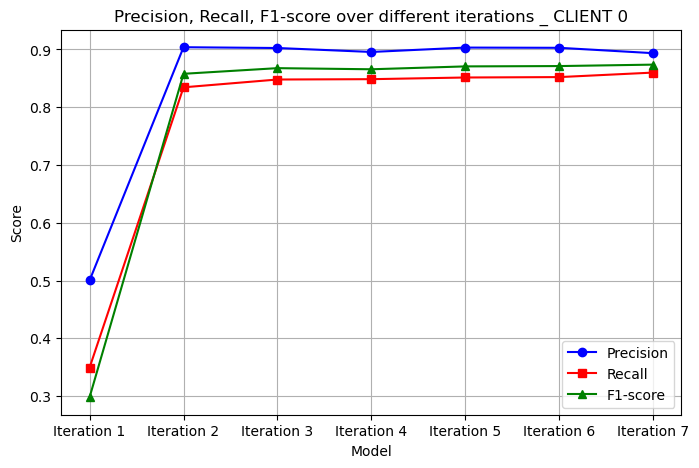

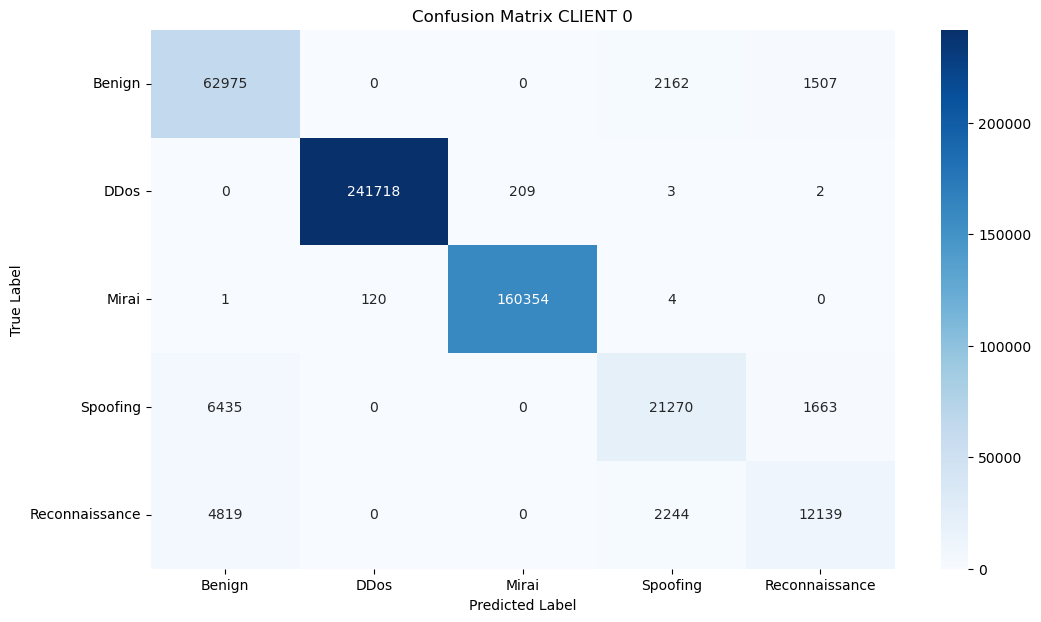

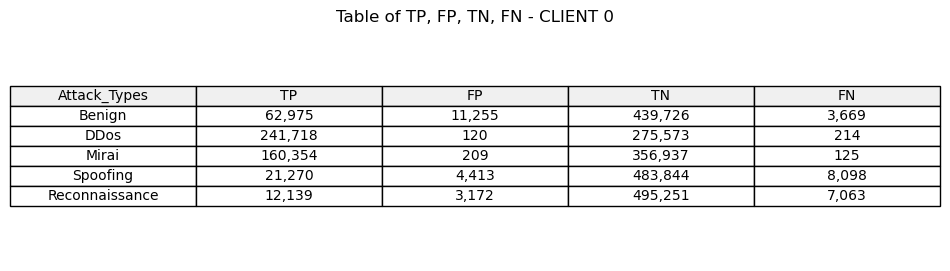

/tmp/ipykernel_91803/3875102694.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)


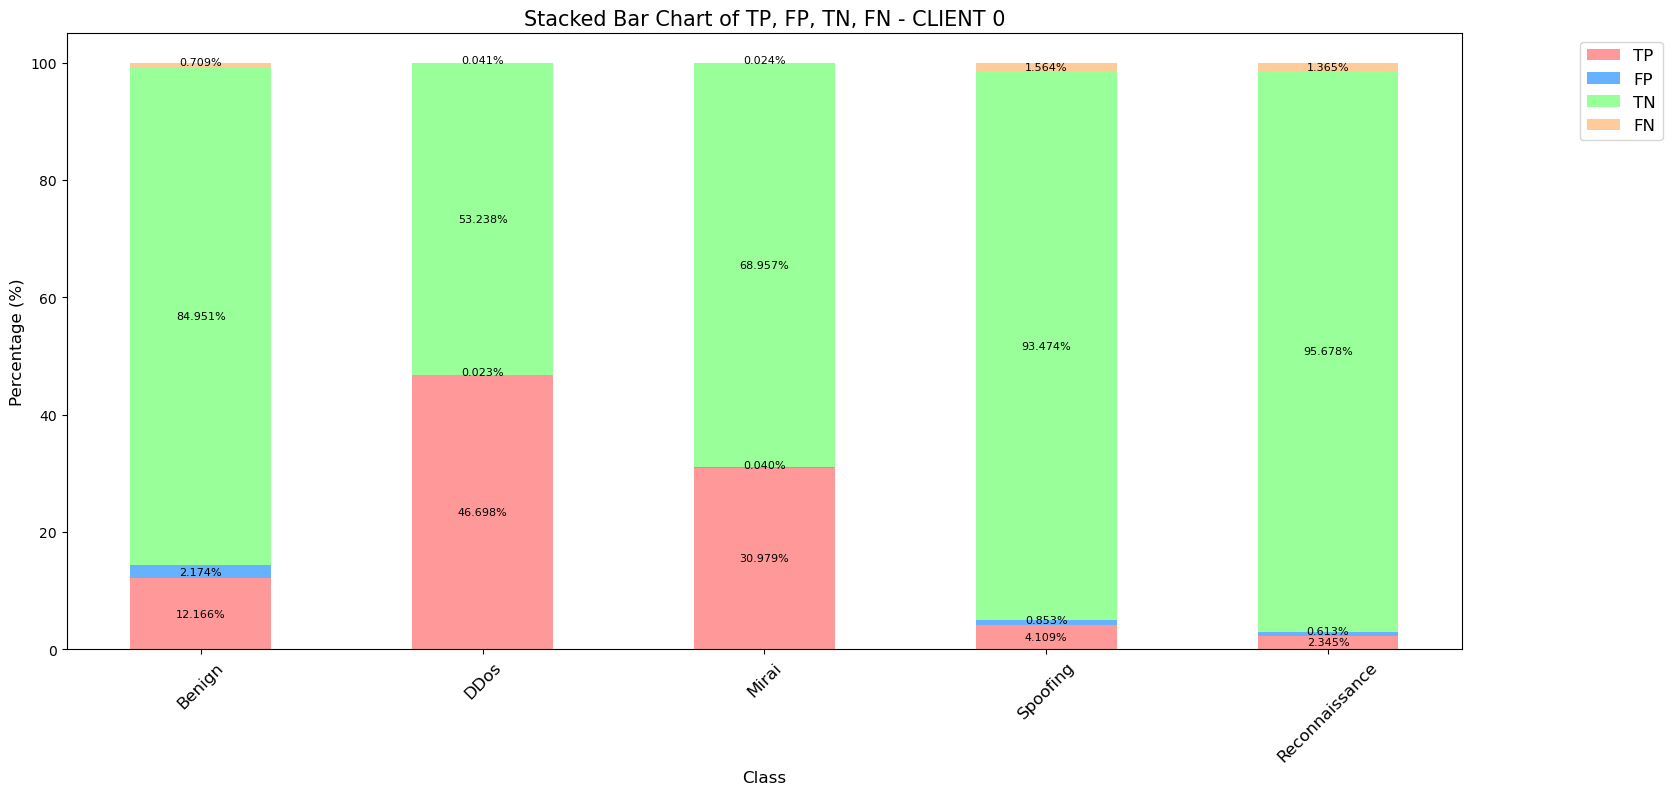

In [3]:
# Client 0
precisions = []
recalls = []
f1s = []

X_test = []
y_test = []
for X_batch, y_batch in test_gens[0].take(stepsTest_Clients[0]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(actual_iterations['client_0']):
    print(models['client_0'][iteration])
    y_pred_pre = models['client_0'][iteration].predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_pre, axis=1)
    
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)

# Vẽ biểu đồ Precision, Recall, F1-score
plt.figure(figsize=(8, 5))
plt.plot(Iterations['client_0'], precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations['client_0'], recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations['client_0'], f1s, marker='^', linestyle='-', label="F1-score", color='green')
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 0")
plt.legend()
plt.grid(True)
plt.savefig(tempdirs[0] + "/pre_recall_f1.png", dpi=300, bbox_inches="tight")
plt.show()

attack_types = ['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 0")
plt.savefig(tempdirs[0] + "/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Tính và vẽ TP, FP, TN, FN
metrics = []
num_classes = len(attack_types)
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    metrics.append([attack_types[i], TP, FP, TN, FN])

df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")
table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                 colColours=["#f0f0f0"] * len(df_metrics.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.set_title("Table of TP, FP, TN, FN - CLIENT 0")
#plt.tight_layout(pad=0.5)
plt.savefig(tempdirs[0] + "/table_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
    df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
) * 100

fig, ax = plt.subplots(figsize=(18, 8))
bottom = np.zeros(len(df_metrics))
colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
    bars = ax.bar(df_metrics["Attack_Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            y_pos = bottom[i] + height / 2
            if height < 1:
                y_pos += 0.5
            ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                    f'{height:.3f}%', ha="center", va="center", rotation=0,
                    fontsize=8, color="black")
    bottom += df_metrics[metric]

ax.set_xlabel("Class", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_title("Stacked Bar Chart of TP, FP, TN, FN - CLIENT 0", fontsize=15)
ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)
ax.legend(loc="upper right", fontsize=12, bbox_to_anchor=(1.15, 1))
#plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[0] + "/stacked_bar_chart_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

2025-06-24 15:41:50.950183: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


362951
<Sequential name=sequential_1, built=True>
11326/11343 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-06-24 15:42:03.487416: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 15:42:03.567250: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 128 bytes spill stores, 128 bytes spill loads



11343/11343 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_1, built=True>
11343/11343 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_1, built=True>
11343/11343 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11343/11343 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_1, built=True>
11343/11343 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11343/11343 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_1, built=True>
11343/11343 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Precision Score Client 1:  [0.5786150103893583, 0.8924905492597747, 0.9001659949720446, 0.8998726938983743, 0.8991173849409415, 0.8991081249180368, 0.9008056888360965]
Recall Score Client 1:  [0.46523387773053243, 0.8456469115770349, 0.8494141279247452, 0.8489497926694621, 0.8553505221665416, 0.8568455316209294, 0.8585226653585056]
F1 Score Client 1:  [0.4558035736257967, 0.8629710667135587, 0.8684245814638757, 0.868

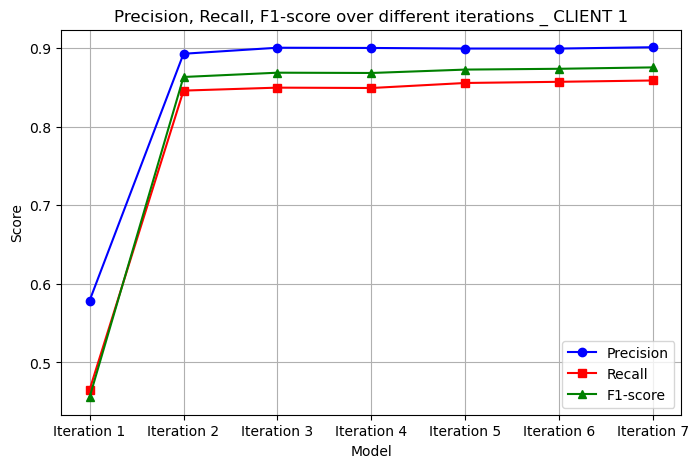

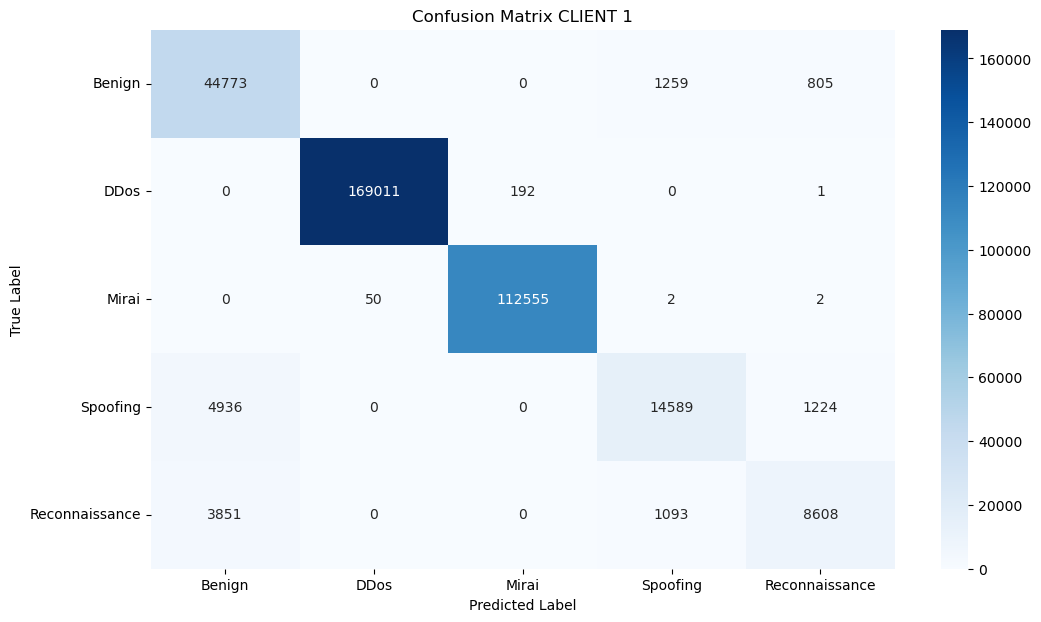

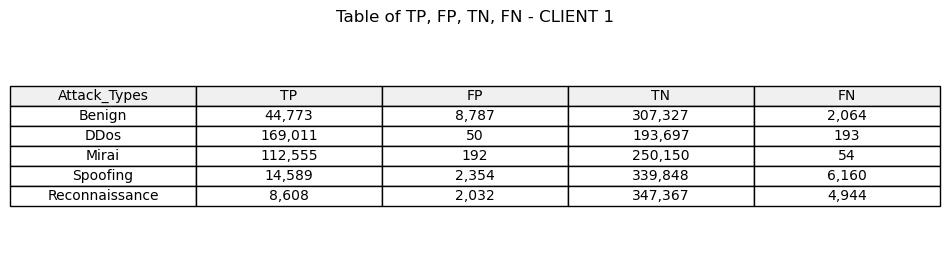

/tmp/ipykernel_91803/3207210425.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)


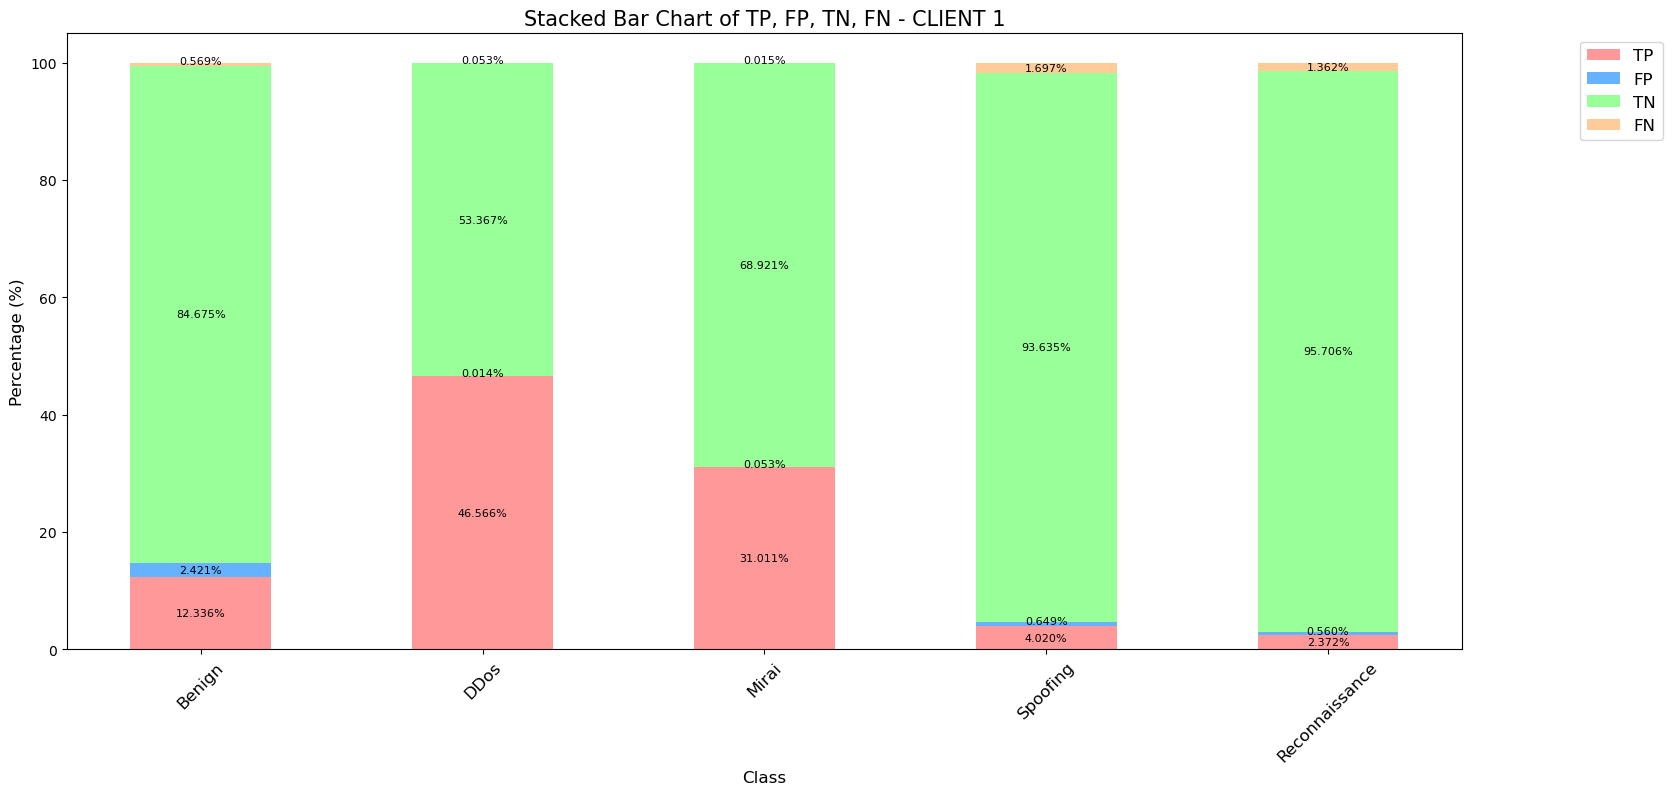

413527
<Sequential name=sequential_2, built=True>
12904/12923 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-06-24 15:43:48.386759: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 12 bytes spill stores, 12 bytes spill loads

2025-06-24 15:43:48.567208: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 384 bytes spill stores, 384 bytes spill loads

2025-06-24 15:43:48.626091: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 16 bytes spill stores, 16 bytes spill loads

2025-06-24 15:43:48.745721: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 272 bytes spill stores, 272 bytes spill loads



12923/12923 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step


/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Sequential name=sequential_2, built=True>
12923/12923 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
<Sequential name=sequential_2, built=True>
12923/12923 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_2, built=True>
12923/12923 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
<Sequential name=sequential_2, built=True>
12923/12923 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_2, built=True>
12923/12923 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
<Sequential name=sequential_2, built=True>
12923/12923 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Precision Score Client 2:  [0.5533427823236281, 0.8891544825340905, 0.9007271768388045, 0.9030891848159708, 0.9023877365600363, 0.9010049144436667, 0.8997219919439207]
Recall Score Client 2:  [0.5118215361468369, 0.8495355252600328, 0.8489667135657963, 0.8467522802318352, 0.8552162172952871, 0.8554791195382977, 0.8502778215560619]
F1 Score Client 2:  [0.49832619369963316, 0.8650865432240827, 0.868280682901205, 0.8673396198008205, 0.8733295743513192, 0.8731085756

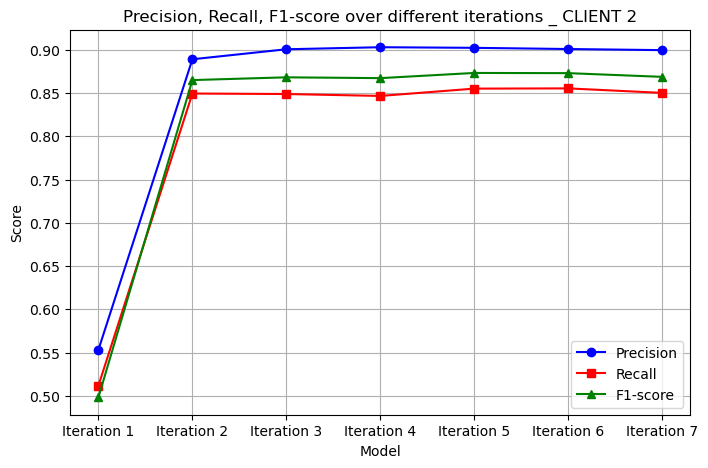

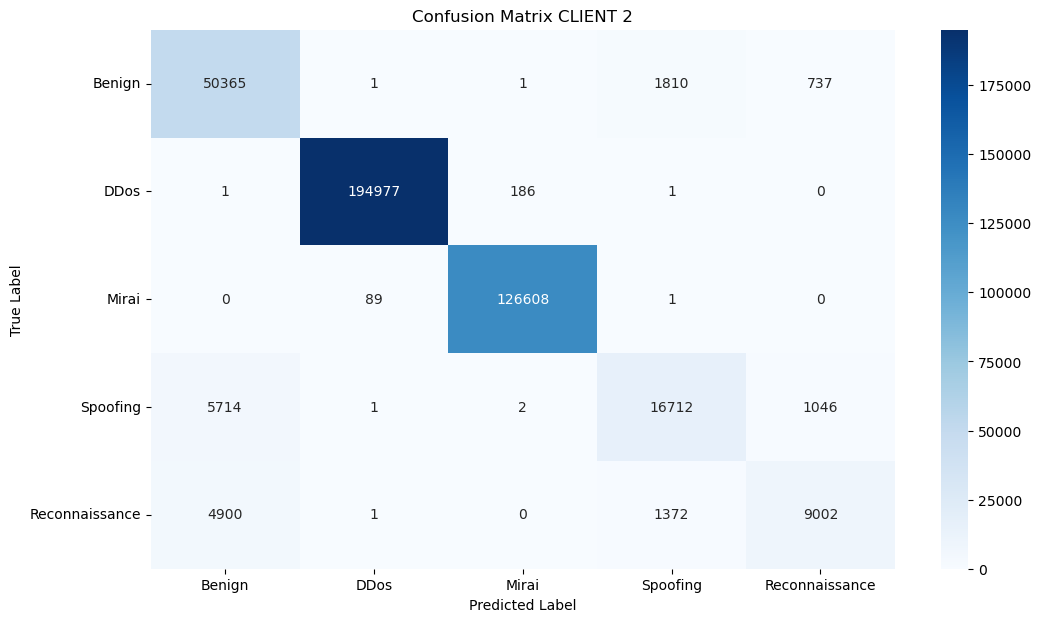

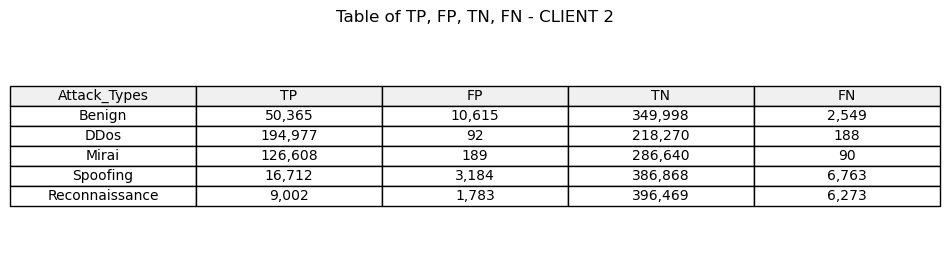

/tmp/ipykernel_91803/3207210425.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)


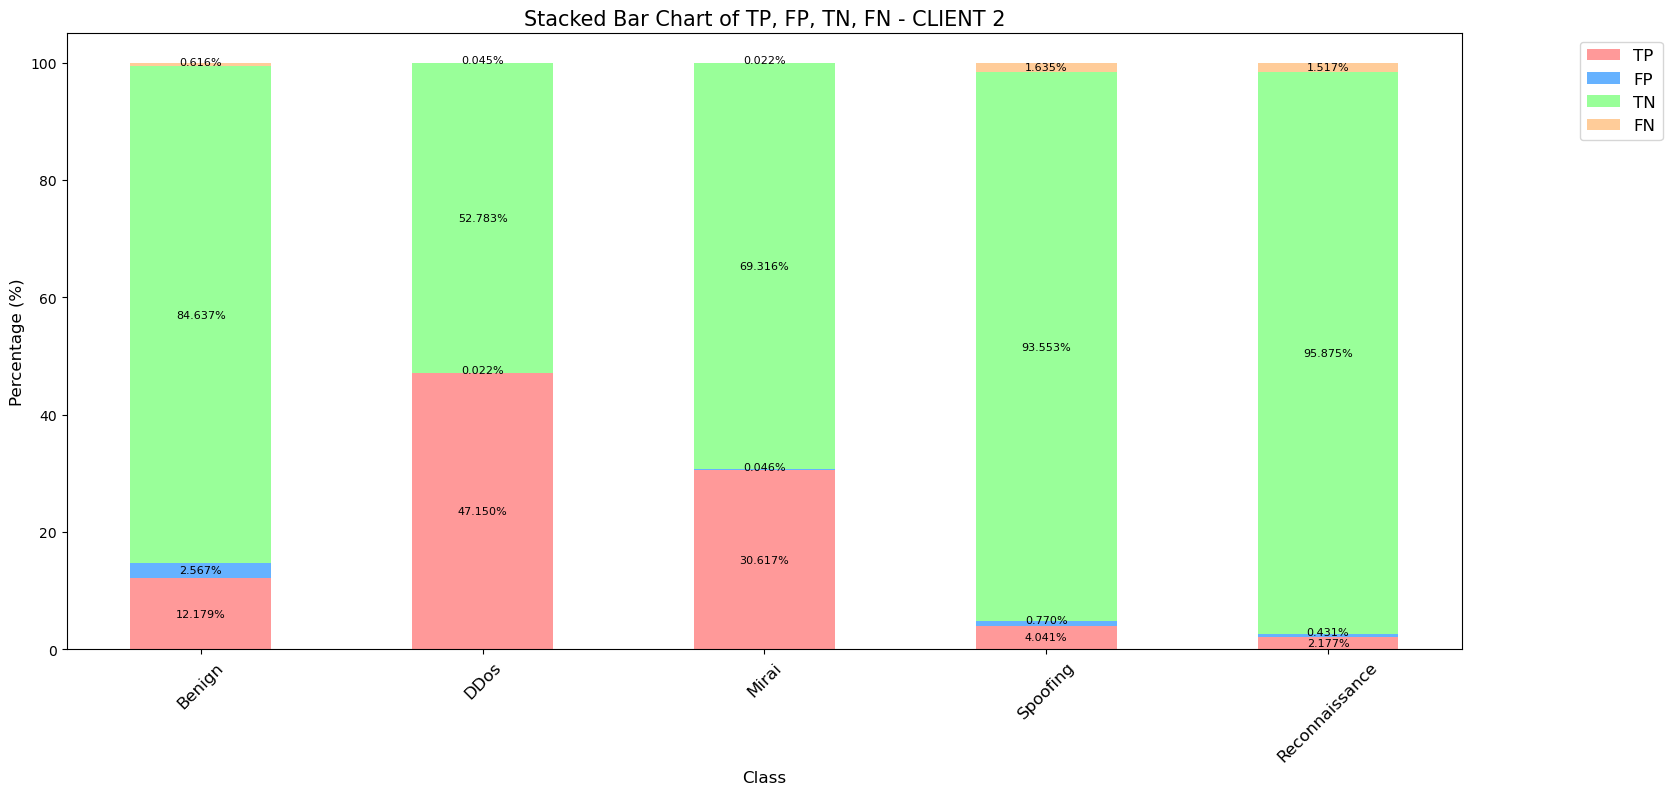

In [4]:
# Lặp cho Client 1 và Client 2
for client_idx in [1, 2]:
    precisions = []
    recalls = []
    f1s = []

    X_test = []
    y_test = []
    for X_batch, y_batch in test_gens[client_idx].take(stepsTest_Clients[client_idx]):
        X_test.append(X_batch.numpy())
        y_test.append(y_batch.numpy())
    X_test = np.concatenate(X_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    print(len(X_test))
    for iteration in range(actual_iterations[f'client_{client_idx}']):
        print(models[f'client_{client_idx}'][iteration])
        y_pred_pre = models[f'client_{client_idx}'][iteration].predict(X_test, verbose=1)
        y_pred = np.argmax(y_pred_pre, axis=1)
        
        precisions.append(precision_score(y_test, y_pred, average='macro'))
        recalls.append(recall_score(y_test, y_pred, average='macro'))
        f1s.append(f1_score(y_test, y_pred, average='macro'))
    print(f"Precision Score Client {client_idx}: ", precisions)
    print(f"Recall Score Client {client_idx}: ", recalls)
    print(f"F1 Score Client {client_idx}: ", f1s)

    # Vẽ biểu đồ Precision, Recall, F1-score
    plt.figure(figsize=(8, 5))
    plt.plot(Iterations[f'client_{client_idx}'], precisions, marker='o', linestyle='-', label="Precision", color='blue')
    plt.plot(Iterations[f'client_{client_idx}'], recalls, marker='s', linestyle='-', label="Recall", color='red')
    plt.plot(Iterations[f'client_{client_idx}'], f1s, marker='^', linestyle='-', label="F1-score", color='green')
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.title(f"Precision, Recall, F1-score over different iterations _ CLIENT {client_idx}")
    plt.legend()
    plt.grid(True)
    plt.savefig(tempdirs[client_idx] + "/pre_recall_f1.png", dpi=300, bbox_inches="tight")
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
    plt.yticks(rotation=360)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix CLIENT {client_idx}")
    plt.savefig(tempdirs[client_idx] + "/confusion_matrix.png", dpi=300, bbox_inches="tight")
    plt.show()

    metrics = []
    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        metrics.append([attack_types[i], TP, FP, TN, FN])

    df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis("off")
    table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
    table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                     colColours=["#f0f0f0"] * len(df_metrics.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax.set_title(f"Table of TP, FP, TN, FN - CLIENT {client_idx}")
    #plt.tight_layout(pad=1.0)
    plt.savefig(tempdirs[client_idx] + "/table_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
    plt.show()

    df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
        df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
    ) * 100

    fig, ax = plt.subplots(figsize=(18, 8))
    bottom = np.zeros(len(df_metrics))
    colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

    for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
        bars = ax.bar(df_metrics["Attack_Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                y_pos = bottom[i] + height / 2
                if height < 1:
                    y_pos += 0.5
                ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                        f'{height:.3f}%', ha="center", va="center", rotation=0,
                        fontsize=8, color="black")
        bottom += df_metrics[metric]

    ax.set_xlabel("Class", fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(f"Stacked Bar Chart of TP, FP, TN, FN - CLIENT {client_idx}", fontsize=15)
    ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)
    ax.legend(loc="upper right", fontsize=12, bbox_to_anchor=(1.15, 1))
    #plt.tight_layout(pad=1.0)
    plt.savefig(tempdirs[client_idx] + "/stacked_bar_chart_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
    plt.show()


Log files: {'client_0': ['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv', 'Iteration_6.csv', 'Iteration_7.csv'], 'client_1': ['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv', 'Iteration_6.csv', 'Iteration_7.csv'], 'client_2': ['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv', 'Iteration_6.csv', 'Iteration_7.csv']}


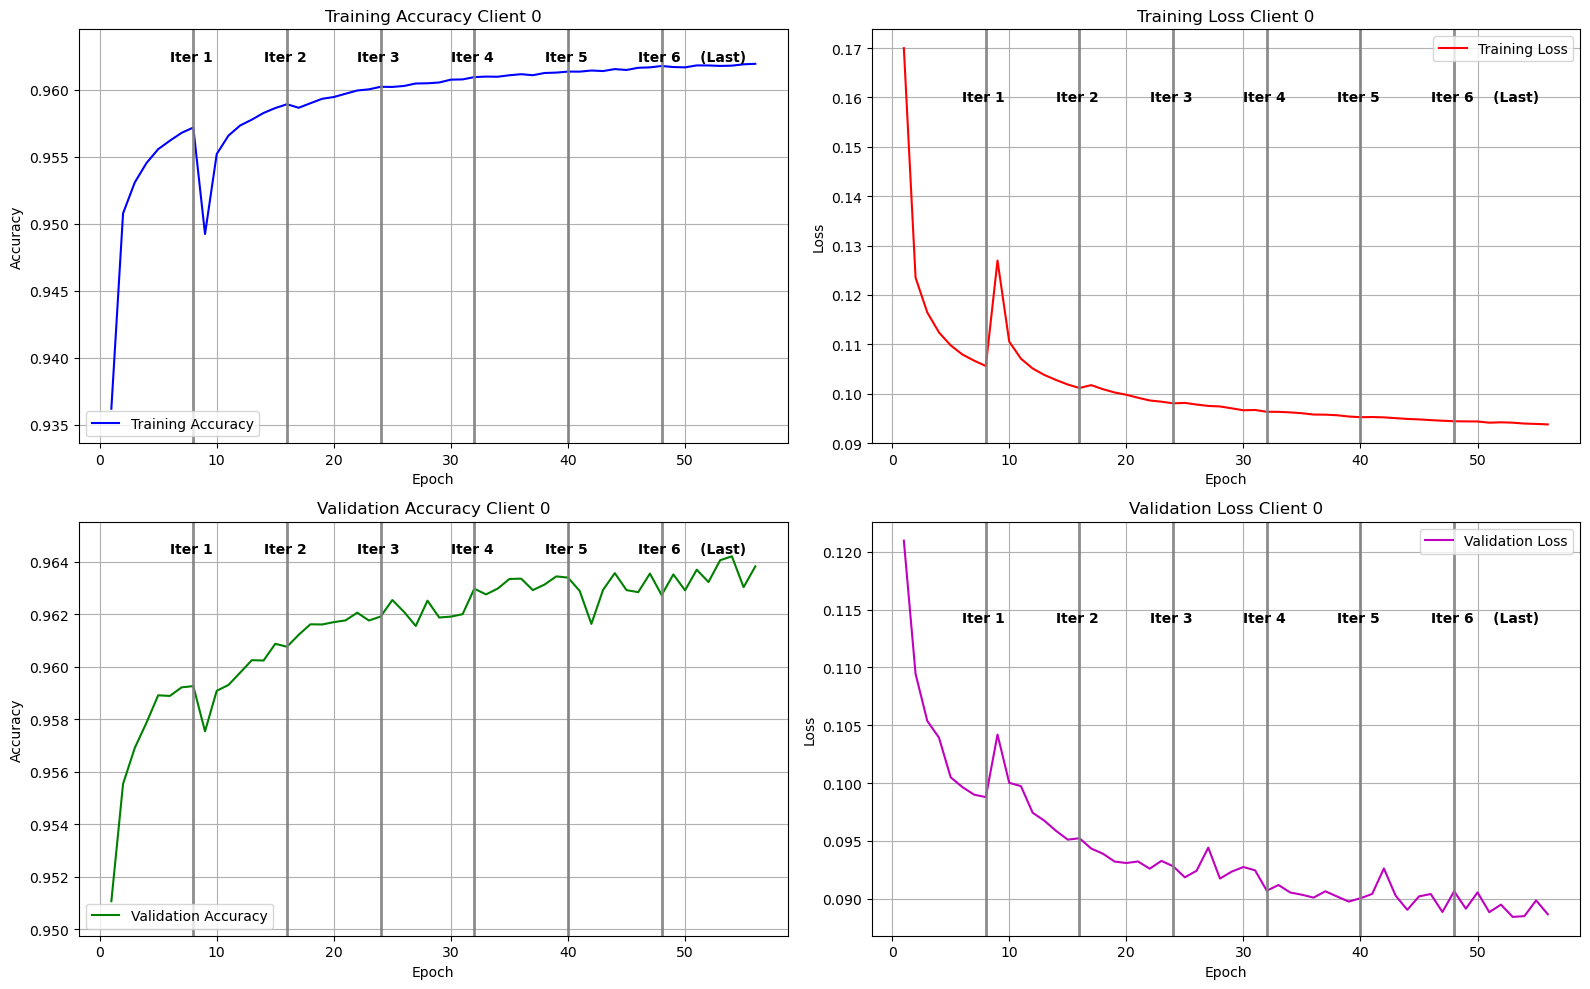

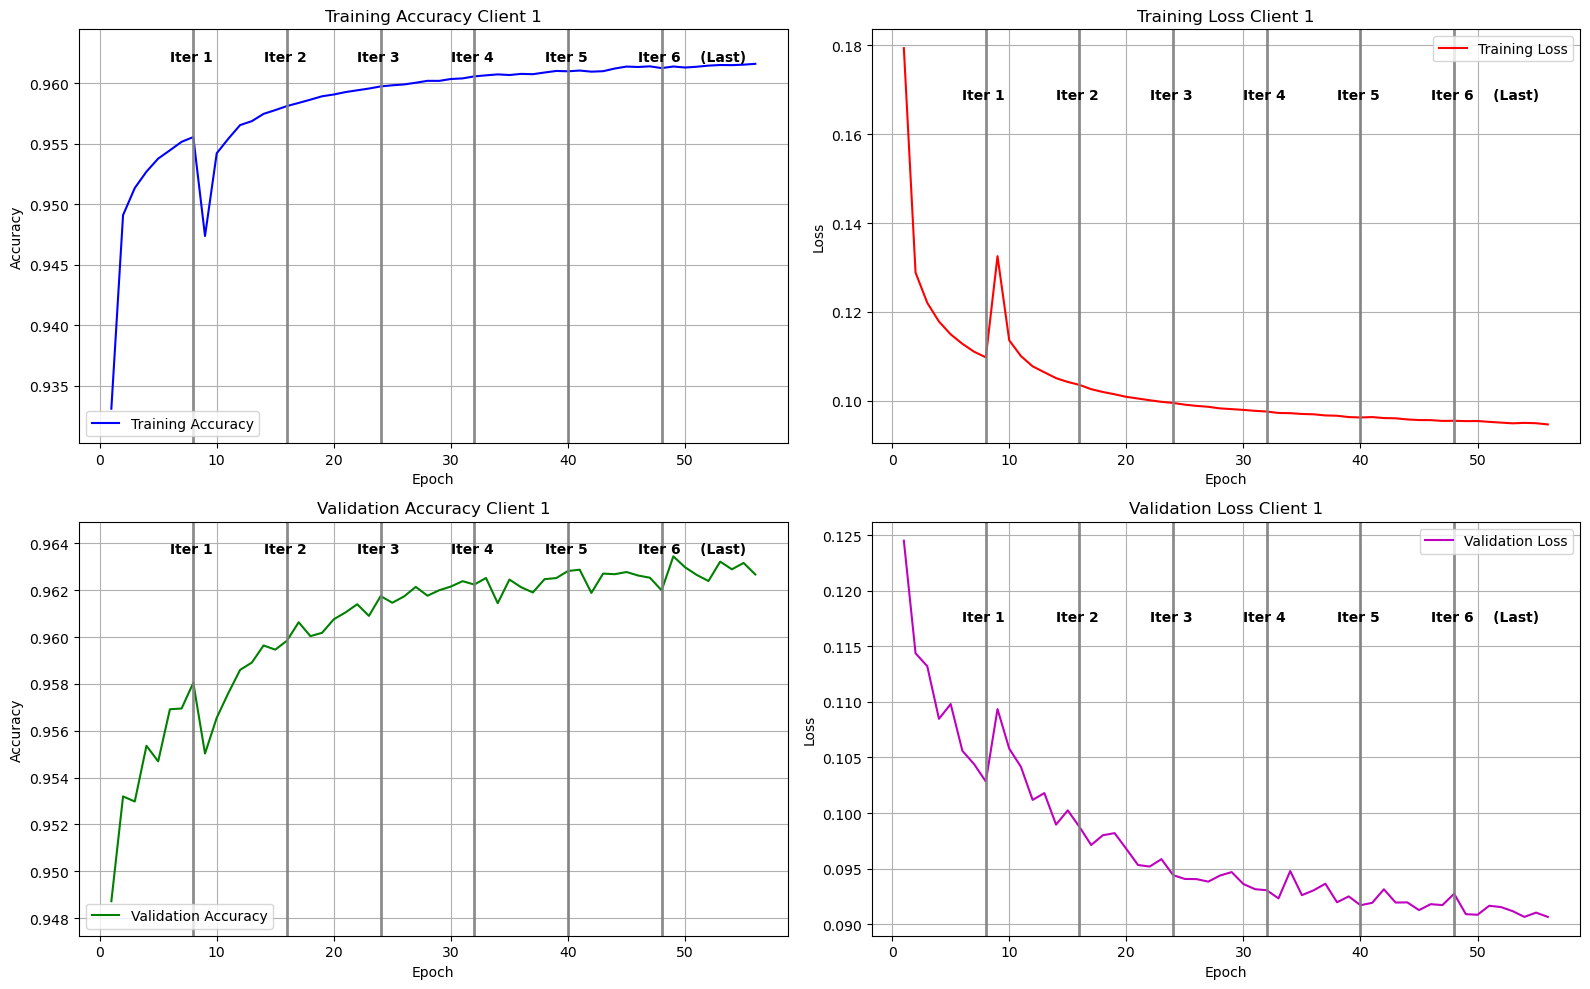

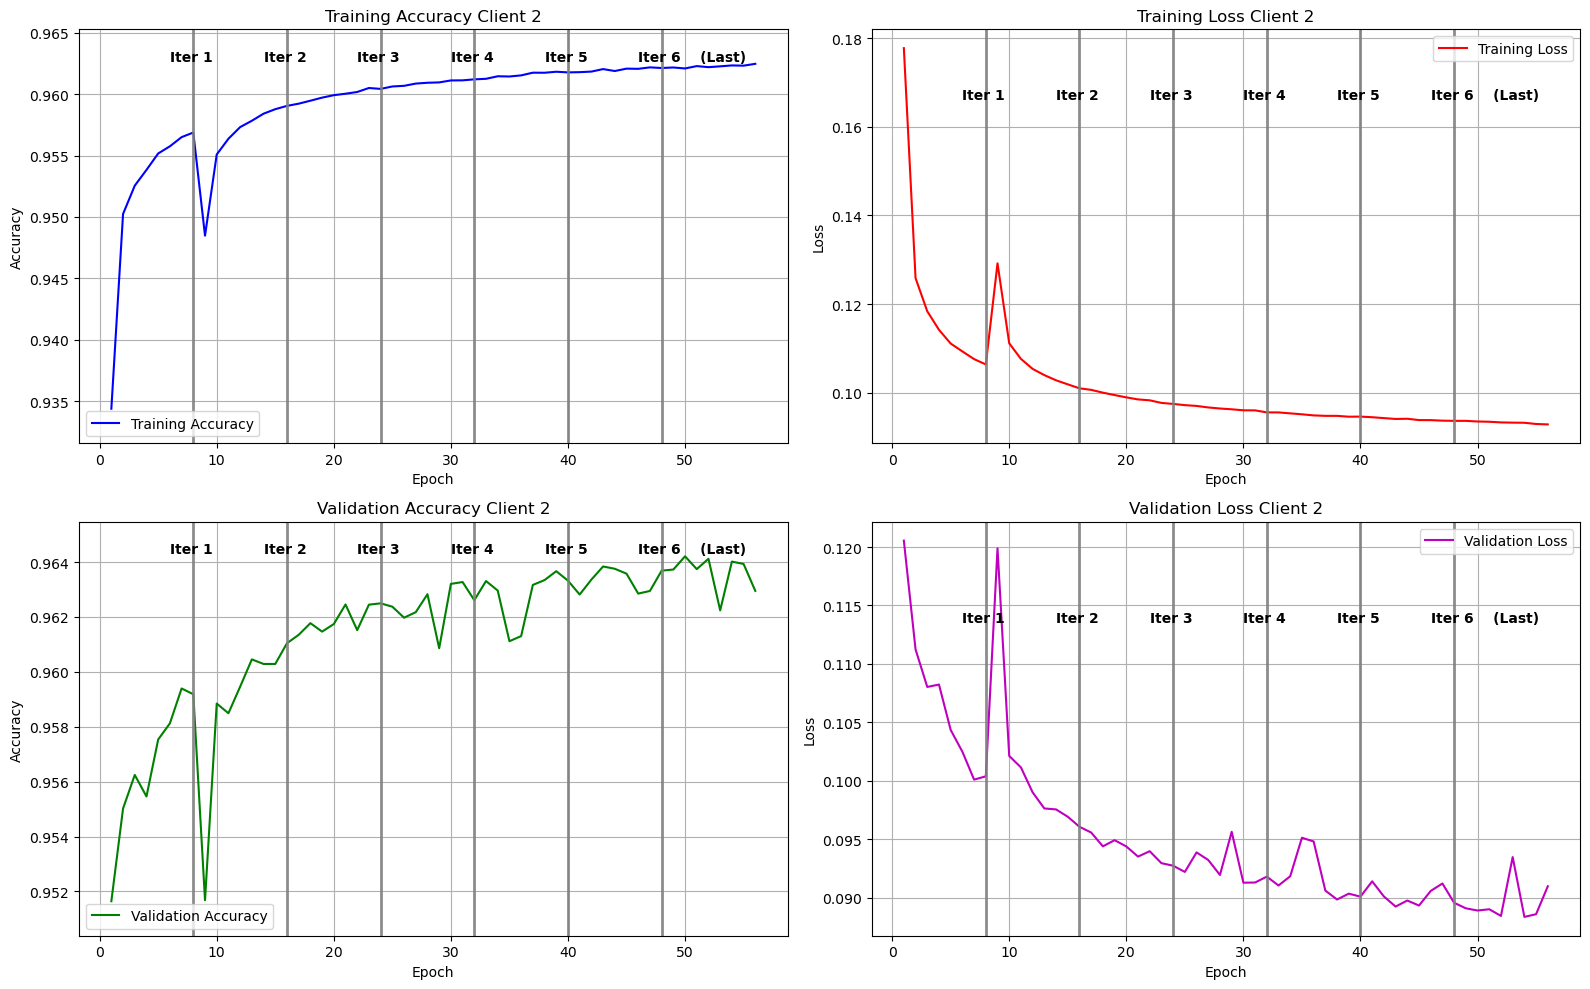

In [5]:
# Phần vẽ biểu đồ log (đã điều chỉnh để tự động tính số epoch)
log_names = {f'client_{i}': [f"Iteration_{j+1}.csv" for j in range(actual_iterations[f'client_{i}'])] for i in range(len(active_clients_list))}
print(f"Log files: {log_names}")

for i in range(len(active_clients_list)):
    all_logs = []
    for log_name in log_names[f'client_{i}']:
        file_path = tempdirs[i] + log_name
        if not os.path.exists(file_path):
            print(f"File {file_path} không tồn tại!")
            continue
        log_part = pd.read_csv(file_path)
        all_logs.append(log_part)

    if not all_logs:
        print(f"No log files found for client_{i}, skipping log plots.")
        continue

    log_df = pd.concat(all_logs, ignore_index=True)
    epochs = range(1, len(log_df) + 1)
    total_epochs = len(log_df)
    epochs_per_iteration = total_epochs // actual_iterations[f'client_{i}']  # Tính số epoch trung bình mỗi iteration

    plt.figure(figsize=(16, 10))

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
    plt.margins(y=0.1)  # Thêm khoảng cách 10% trên cùng để chứa nhãn
    max_acc = max(log_df['accuracy']) if not log_df['accuracy'].empty else 1.0
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        boundary_epoch = iter_idx * epochs_per_iteration  # Vị trí đường gạch dựa trên số epoch thực tế
        plt.axvline(x=boundary_epoch, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        y_pos = max_acc
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(boundary_epoch - 2, y_pos, f'Iter {iter_idx}', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
        else:
            plt.text(boundary_epoch - 2, y_pos, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
    plt.title(f'Training Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Validation Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, log_df['val_accuracy'], 'g-', label='Validation Accuracy')
    plt.margins(y=0.1)  # Thêm khoảng cách 10% trên cùng để chứa nhãn
    max_val_acc = max(log_df['val_accuracy']) if not log_df['val_accuracy'].empty else 1.0
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        boundary_epoch = iter_idx * epochs_per_iteration  # Vị trí đường gạch dựa trên số epoch thực tế
        plt.axvline(x=boundary_epoch, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        y_pos = max_val_acc
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(boundary_epoch - 2, y_pos, f'Iter {iter_idx}', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
        else:
            plt.text(boundary_epoch - 2, y_pos, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
    plt.title(f'Validation Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss')
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        boundary_epoch = iter_idx * epochs_per_iteration  # Vị trí đường gạch dựa trên số epoch thực tế
        plt.axvline(x=boundary_epoch, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(boundary_epoch - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(boundary_epoch - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Training Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Validation Loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss')
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        boundary_epoch = iter_idx * epochs_per_iteration  # Vị trí đường gạch dựa trên số epoch thực tế
        plt.axvline(x=boundary_epoch, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(boundary_epoch - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(boundary_epoch - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Validation Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(tempdirs[i] + "/train_valid_acc_loss.png", dpi=300, bbox_inches="tight")
    plt.show()

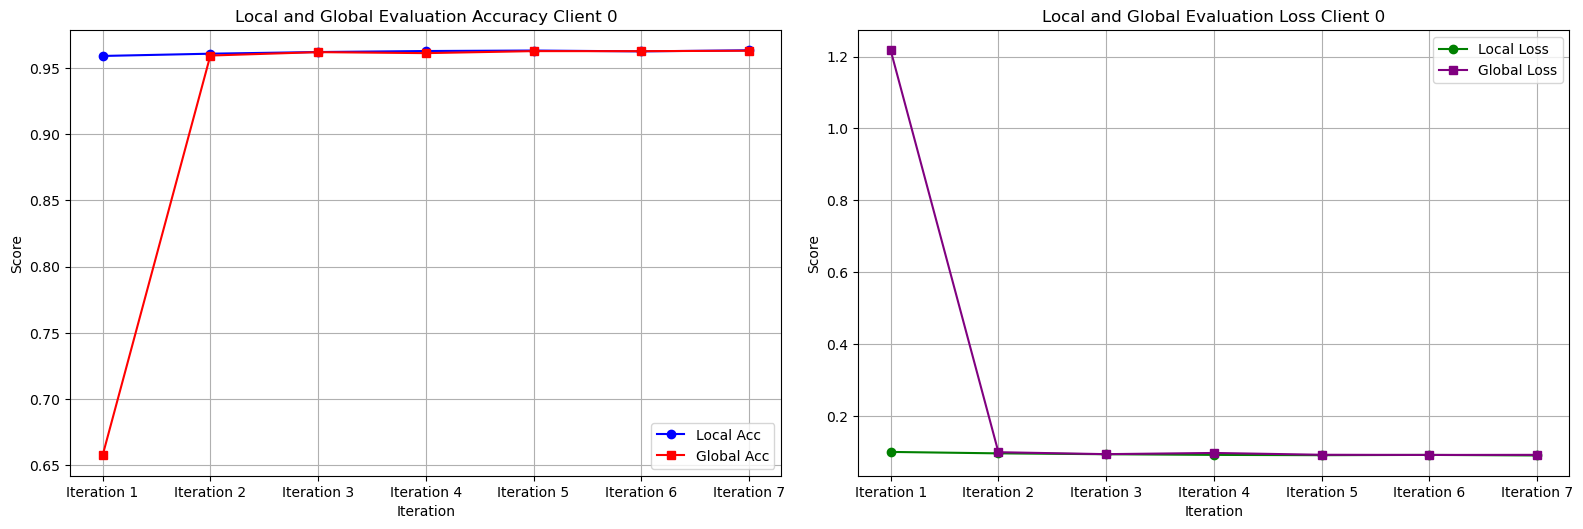

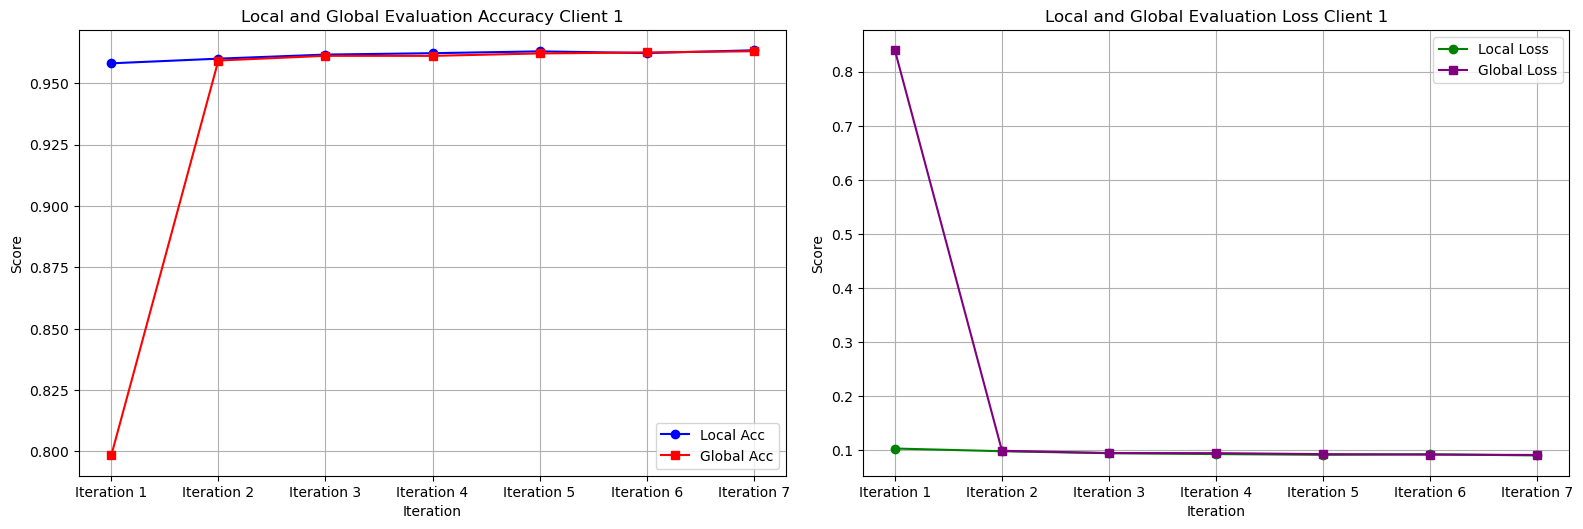

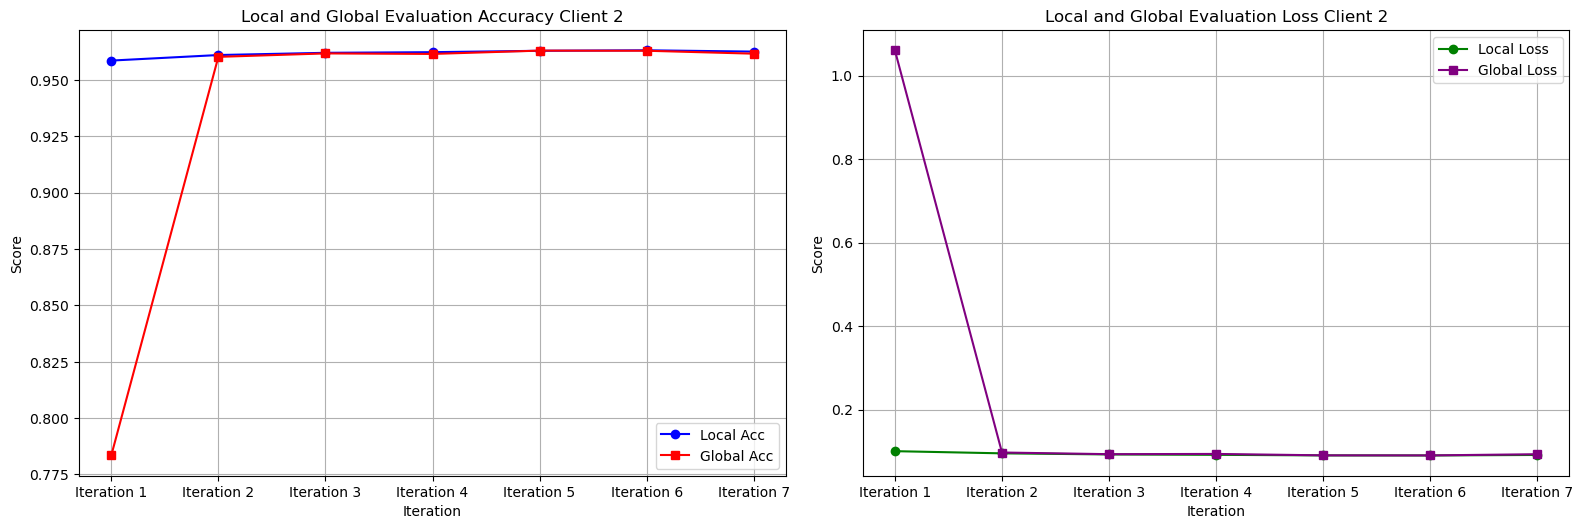

In [6]:
# Phần vẽ local/global evaluation
for i in range(len(active_clients_list)):
    file_path_local = tempdirs[i] + "local_val.csv"
    file_path_global = tempdirs[i] + "global_val.csv"
  
    local_val = pd.read_csv(file_path_local)
    global_val = pd.read_csv(file_path_global)
    plt.figure(figsize=(16, 10))
    plt.subplot(2, 2, 1)
    plt.plot(Iterations[f'client_{i}'], local_val['local_acc'], marker='o', linestyle='-', label="Local Acc", color='blue')
    plt.plot(Iterations[f'client_{i}'], global_val['global_acc'], marker='s', linestyle='-', label="Global Acc", color='red')
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Local and Global Evaluation Accuracy Client {i}")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(Iterations[f'client_{i}'], local_val['local_loss'], marker='o', linestyle='-', label="Local Loss", color='green')
    plt.plot(Iterations[f'client_{i}'], global_val['global_loss'], marker='s', linestyle='-', label="Global Loss", color='purple')
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Local and Global Evaluation Loss Client {i}")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(tempdirs[i] + "/evaluation_acc_loss.png", dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
df = pd.read_csv(resource_usage)

# Tính toán thời gian đã trôi qua (tính bằng giây) từ lúc bắt đầu
df['elapsed_time'] = df['timestamp'] - df['timestamp'].iloc[0]

# Tạo một figure chứa 4 biểu đồ con (2 hàng, 2 cột)
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Phân tích Hiệu năng Tài nguyên Hệ thống', fontsize=16)

# 1. Biểu đồ CPU Usage
axs[0, 0].plot(df['elapsed_time'], df['cpu_usage'], label='CPU Usage')
axs[0, 0].set_title('CPU Usage Over Time')
axs[0, 0].set_xlabel('Time (seconds)')
axs[0, 0].set_ylabel('Usage (%)')
axs[0, 0].grid(True)
axs[0, 0].set_ylim(0, 101)  # Giới hạn trục y từ 0-100%

# 2. Biểu đồ RAM Usage
axs[1, 0].plot(df['elapsed_time'], df['ram_usage_mb'], color='orange', label='RAM Usage')
axs[1, 0].set_title('RAM Usage Over Time')
axs[1, 0].set_xlabel('Time (seconds)')
axs[1, 0].set_ylabel('Usage (MB)')
axs[1, 0].grid(True)

# 3. Biểu đồ GPU Usage
axs[0, 1].plot(df['elapsed_time'], df['gpu_usage'], color='green', label='GPU Usage')
axs[0, 1].set_title('GPU Usage Over Time')
axs[0, 1].set_xlabel('Time (seconds)')
axs[0, 1].set_ylabel('Usage (%)')
axs[0, 1].grid(True)
axs[0, 1].set_ylim(0, 101)  # Giới hạn trục y từ 0-100%

# 4. Biểu đồ GPU Memory Usage
axs[1, 1].plot(df['elapsed_time'], df['gpu_mem_usage_mb'], color='red', label='GPU Memory Usage')
axs[1, 1].set_title('GPU Memory Usage Over Time')
axs[1, 1].set_xlabel('Time (seconds)')
axs[1, 1].set_ylabel('Usage (MB)')
axs[1, 1].grid(True)

# Tự động điều chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Để không bị che mất suptitle

# Lưu biểu đồ thành file ảnh
output_image_path = os.path.join(os.path.dirname(csv_path), 'resource_usage_plot.png')
plt.savefig(output_image_path)
print(f"Đã lưu biểu đồ vào file: {output_image_path}")

# Hiển thị biểu đồ
plt.show()
